**Code working on extracting attendance data from wikipedia pages**

In [14]:
#  Selecting the team and seasons that the program will scrape from Wikipedia. 

team = "Derby County"
seasons = ["2014-15","2015-16","2016-17","2017-18","2018-19","2019-20"]

# Importing wikipedia and reading the page.

import pandas as pd
import wikipedia as wp

fix = pd.DataFrame()

for season in seasons:
    wikipage = f"{season} {team} F.C season"
    html = wp.page(wikipage).html().encode("UTF-8")
    try: 
        df = pd.read_html(html)  
    except IndexError:
        df = pd.read_html(html)[0]

    # Filtering through the tables, and drawing out those with the term "ref" in. This term generally only found in the fixtures tables. 

    refs = []

    for i in df:
        if len(i.columns) == 5: 
            if i[4].str.contains("Ref")[1] == True:
                refs.append(i)  


    # Each fixture is saved as an independant table, with two rows holding all the information. This flattens all the the tables into one row, and creates a dataframe from them.

    for i in range(len(refs)):
        refs[i] = refs[i].to_numpy().flatten()
        
    fix1 = pd.DataFrame(refs)
    
#     Program then concatenates the dataframes from different seasons iterated through, and finally resets the index so each value has a unique index. 
    
    fix = pd.concat([fix1, fix])

fix.reset_index(drop=True, inplace=True)

**Examining the missing data in the imported dataset**

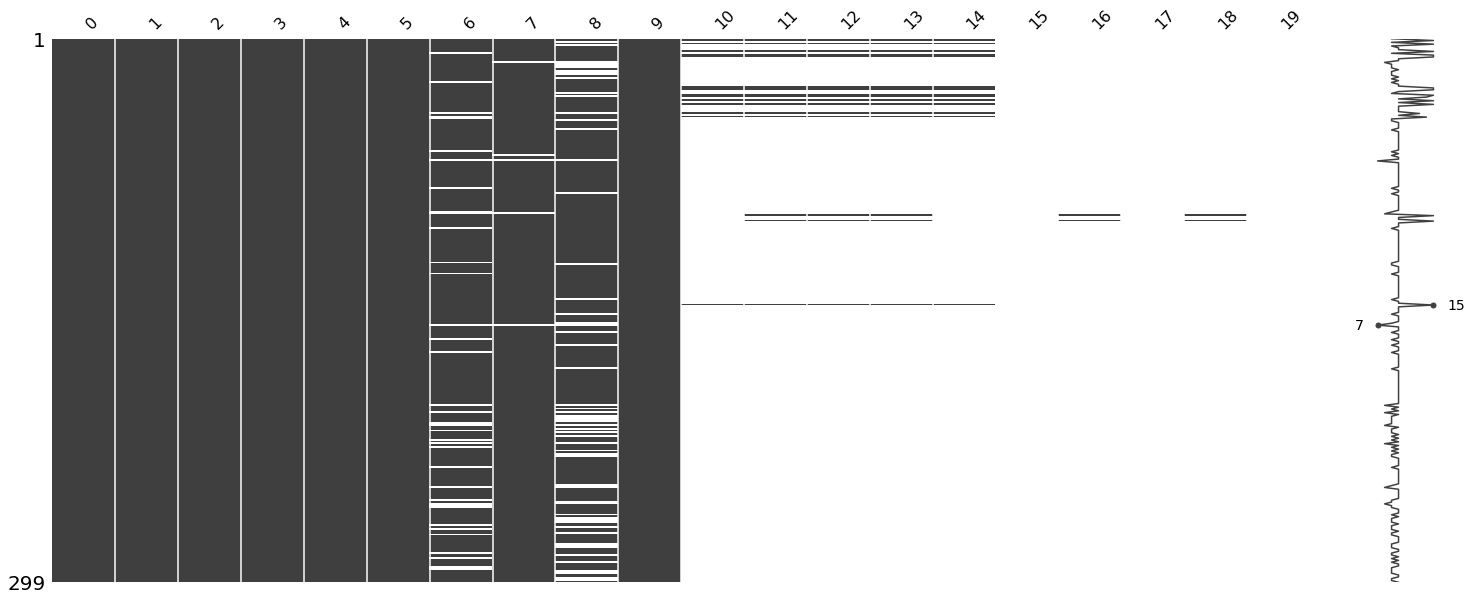

In [15]:
import missingno
%matplotlib inline

missingno.matrix(fix)

In [16]:
# Dropping columns 10 through to 19 due to a lack of data. 

for i in range(10,20):
    fix.drop(i, inplace=True, axis=1)

In [17]:
fix.head()

,0,1,2,3,4,5,6,7,8,9
0,10 July 2019 Friendly,Sarasota Metropolis,0â2,Derby County,"Bradenton, Florida",23:00 BST,NaN,Report,"Marriott 71', 77'",Stadium: IMG AcademyAttendance: N/AReferee: N/A
1,14 July 2019 Friendly,Bristol City,1â2,Derby County,"Bradenton, Florida",14:30 BST,Baker 57',Report,Bennett 13' Anya 43',Stadium: IMG AcademyAttendance: N/AReferee: N/A
2,28 July 2019 Friendly,Rangers,1â0,Derby County,Glasgow,15:00 BST,KatiÄ 83',[11],NaN,"Stadium: IbroxAttendance: 19,843Referee: Kevin..."
3,5 August 2019 1,Huddersfield Town,1â2,Derby County,Huddersfield,19:45 BST,Ahearne-Grant 30' (pen.),Report,"Lawrence 22', 25'","Stadium: John Smith's StadiumAttendance: 22,59..."
4,10 August 2019 2,Derby County,0â0,Swansea City,Derby,15:00 BST,Waghorn 42',Report,NaN,"Stadium: Pride Park StadiumAttendance: 27,337R..."


**Starting to clean the data**

In [18]:
# Working with the first feature. Splitting into date and gameweek round. 

import re

fix["Gameweek"] = ""

for i in range(len(fix[0])):
    
    if not re.search('[a-zA-Z]', fix[0][i].split()[-1]):
        fix["Gameweek"][i] = fix[0][i].split()[-1]
        fix[0][i] = " ".join(fix[0][i].split()[:-1])
    
    if re.search('[a-zA-Z]', fix[0][i].split()[-1]): 
        fix["Gameweek"][i] = " ".join(fix[0][i].split("20")[1].split()[1:])
        fix[0][i] = " ".join(fix[0][i].split()[:3])


In [19]:
# Splitting column nine to extract the attendance figure

fix["Attendance"] = ""

def attend(x):
    return "".join(re.findall(r'\d+', x))

fix["Attendance"] = fix[9].apply(lambda x: attend(x))

In [20]:
# Giving the table more readable column names

fix.columns = ["Date", "Home Side", "Score", "Away Side", "Venue", "KO Time", "Home Scorer", "Report", "Away Scorer", 
               "Referee", "Gameweek", "Attendance"]

# Dropping needless columns

fix.drop(["Referee", "Report", "Home Scorer", "Away Scorer"], axis = 1, inplace = True)

In [21]:
# Splitting score into one home and one away score, dropping the joint score column.

fix["Home Score"] = fix["Score"].apply(lambda x: re.findall(r'\d+', x)[0])
fix["Away Score"] = fix["Score"].apply(lambda x: re.findall(r'\d+', x)[1])

fix.drop("Score", axis=1, inplace = True)

In [22]:
# Converting all columns into useful data types

fix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 9 columns):
Date          299 non-null object
Home Side     299 non-null object
Away Side     299 non-null object
Venue         299 non-null object
KO Time       299 non-null object
Gameweek      299 non-null object
Attendance    299 non-null object
Home Score    299 non-null object
Away Score    299 non-null object
dtypes: object(9)
memory usage: 21.1+ KB


In [23]:
# Converting the numeric columns into floats, and any blank object items into NaN cells. 

import numpy as np

def float_it(x):
    try:
        return float(x)
    
    except Exception:
        return np.NaN

Nums = ["Attendance", "Home Score", "Away Score"]
    
for i in Nums:
    fix[i] = fix[i].apply(lambda x: float_it(x))

In [24]:
# Converting dates into a more useful format

fix["Date"] = pd.to_datetime(fix["Date"])#

fix.head()

,Date,Home Side,Away Side,Venue,KO Time,Gameweek,Attendance,Home Score,Away Score
0,2019-07-10,Sarasota Metropolis,Derby County,"Bradenton, Florida",23:00 BST,Friendly,NaN,0.0,2.0
1,2019-07-14,Bristol City,Derby County,"Bradenton, Florida",14:30 BST,Friendly,NaN,1.0,2.0
2,2019-07-28,Rangers,Derby County,Glasgow,15:00 BST,Friendly,19843.0,1.0,0.0
3,2019-08-05,Huddersfield Town,Derby County,Huddersfield,19:45 BST,1,22596.0,1.0,2.0
4,2019-08-10,Derby County,Swansea City,Derby,15:00 BST,2,27337.0,0.0,0.0


In [28]:
fix.to_csv(f"{team} {seasons[0]} to {seasons[-1]}", index=False)